In [14]:
import math

import matplotlib.pyplot as plt
import numpy as np

In [3]:
def feature_pareto(k: float, q: float, D: np.ndarray) -> np.ndarray:
    """
    Calculate the distribution of features larger than D based on the Pareto principle.

    n(>D) = k * D^(-q)
    """
    return k * D ** (-q)


def shaded_area(k: float, q: float, D: np.ndarray, theta: np.ndarray):
    D = D.reshape(-1, 1)  # Ensure D is a column vector
    theta = theta.reshape(1, -1)  # Ensure theta is a row vector
    density = feature_pareto(k, q, D)
    average_distance = np.sqrt(1 / (np.pi * density + 1e-10))

    return D * D * np.tan(theta), average_distance, density

In [4]:
k = 5.0e-3
q = 3.0
D = np.linspace(1e0, 1e1, 20)
theta = np.linspace(30, 70, 90) * np.pi / 180

D_shaded, average_distance, density = shaded_area(k, q, D, theta)

# Feature Distribution

To begin, the core assumption here is that the density of features on a scale relevant to the rover is power law-distributed as follows:

$$n(>D) = kD^{-q}$$

$k$ and $q$ are site-dependent, but generally take values on the order of $10^{-3} \text{ m}^{-2 + q} $ and $1.0$. For our exploration here, we use $k = 5.0 \times 10^{-3} \text{ m}^{-5} $ and $q=3.0$

The proportion that is shaded (subject to the precise distribution of craters and boulders in the region) can therefore be calculated as the product of the areal density of the features and the size of their shadow. The distance of the Sun from the moon allows us to model it as infinitely far; the only distortion is therefore in the direction of the light.

The area of the shade cast by objects of size $D$ is given by $D^2\tan\theta$.

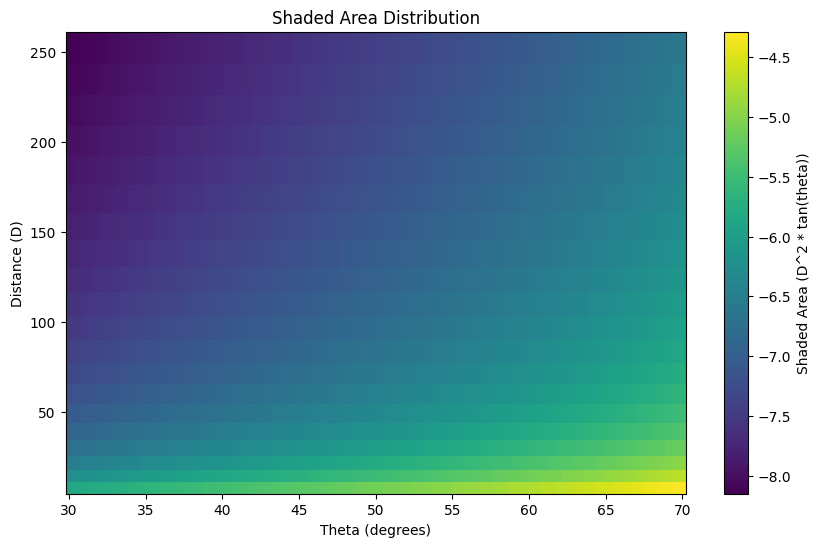

In [5]:
# Plotting the shaded area
plt.figure(figsize=(10, 6))
plt.pcolormesh(
    theta * 180 / np.pi,
    average_distance,
    np.log(D_shaded * density),
    shading="auto",
    cmap="viridis",
)
plt.colorbar(label="Shaded Area (D^2 * tan(theta))")
plt.xlabel("Theta (degrees)")
plt.ylabel("Distance (D)")
plt.title("Shaded Area Distribution")
plt.show()

We can see that there is a monotonic increase in the proportion of the surface that is shaded with increasing solar angle, regardless of the size of feature under consideration.

In [6]:
k = 5.0e-3
q = 3.0
D = np.linspace(1e0, 1e1, 20)
theta = np.linspace(30, 70, 10) * np.pi / 180

D = D.reshape(-1, 1)  # Ensure D is a column vector
theta = theta.reshape(1, -1)  # Ensure theta is a row vector

shadow_length_per_feature = D * np.tan(theta)
shaded_area_per_feature = D * D * np.tan(theta)
average_distance_per_feature = np.sqrt(1 / (np.pi * feature_pareto(k, q, D) + 1e-10))

<Figure size 1000x600 with 0 Axes>

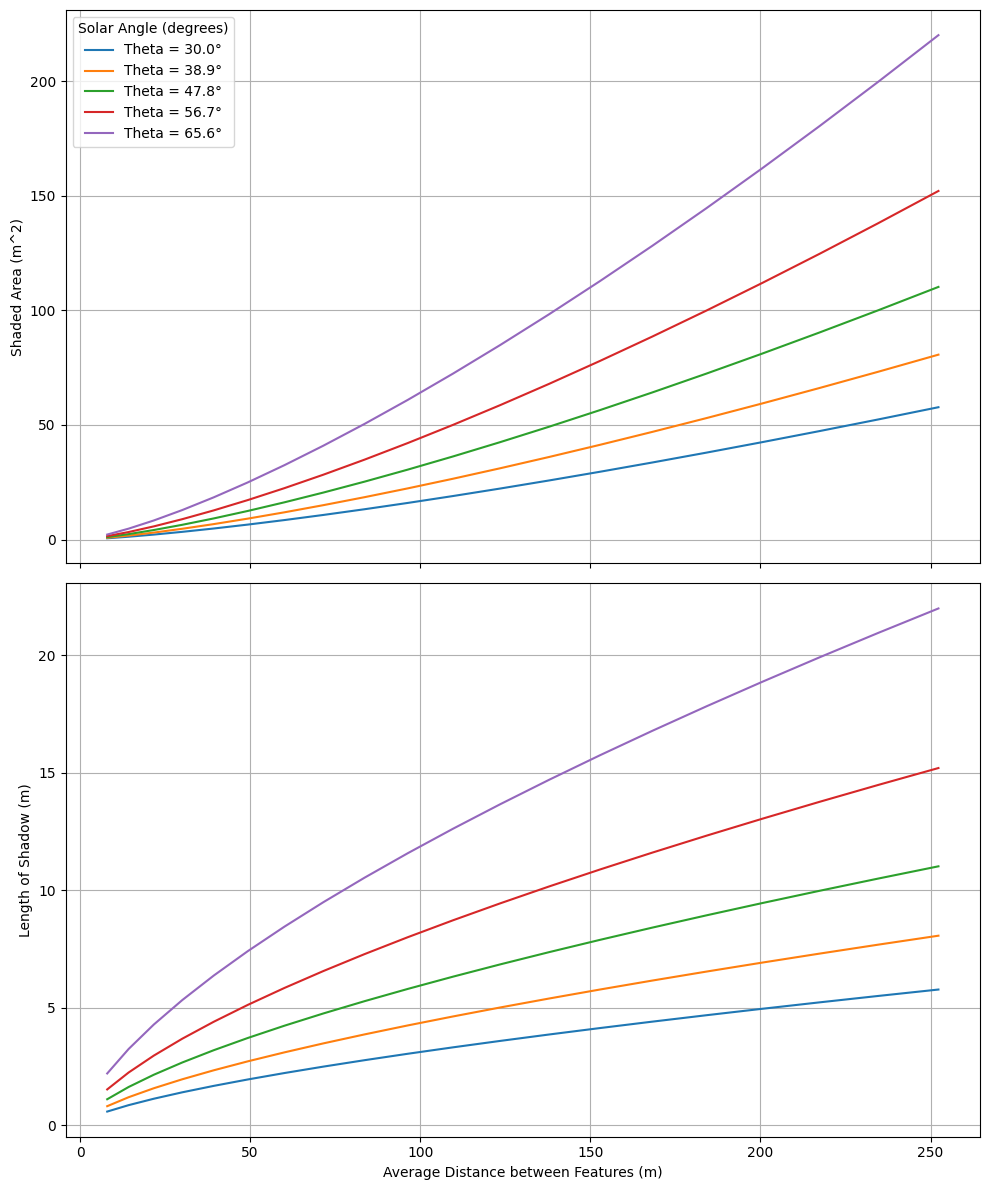

In [7]:
plt.figure(figsize=(10, 6))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)


for i in range(0, shaded_area_per_feature.shape[1], 2):
    ax1.plot(
        average_distance_per_feature,
        shaded_area_per_feature[:, i],
        label=f"Theta = {theta[0, i] * 180 / np.pi:.1f}°",
    )

ax1.set_ylabel("Shaded Area (m^2)")
ax1.grid()
ax1.legend(title="Solar Angle (degrees)")

for i in range(0, shadow_length_per_feature.shape[1], 2):
    ax2.plot(
        average_distance_per_feature,
        shadow_length_per_feature[:, i],
        label=f"Theta = {theta[0, i] * 180 / np.pi:.1f}°",
    )

ax2.set_xlabel("Average Distance between Features (m)")
ax2.set_ylabel("Length of Shadow (m)")
ax2.grid()
plt.tight_layout()
plt.show()

# Analysis

## What does this tell us about the surface potential distribution on a rover-relevant scale?

We can see that given certain dimensions for the length of the shadow cast, which is relevant to the charge-collecting capcacitor array on the rover, the distance between the features capable of creating such a shadow increases **superlinearly**.

The solar angle serves as a scaling factor for the length of the shadow cast. However, because of the dependence on the availability of local variations for successful power generation, this likely constrains our choice of target location to **higher latitudes**.

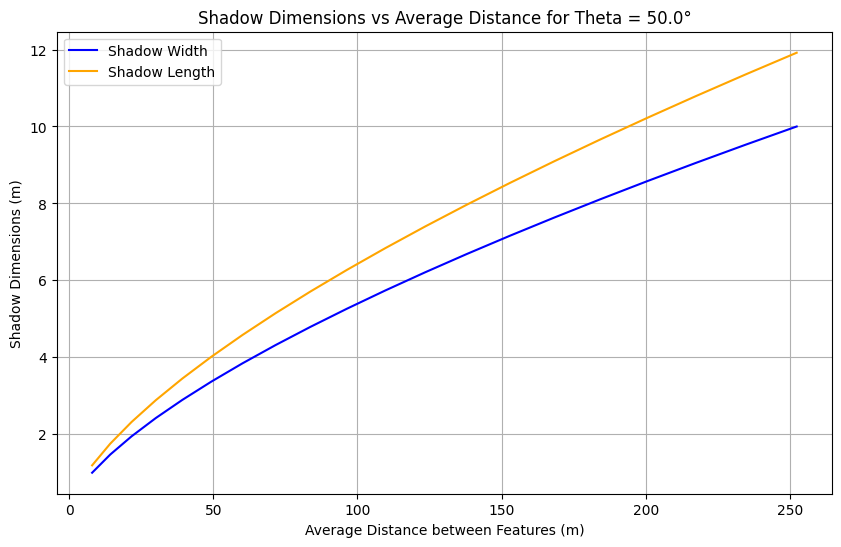

In [13]:
k = 5.0e-3
q = 3.0
theta = 50 * np.pi / 180
D = np.linspace(1e0, 1e1, 20)
average_distance = np.sqrt(1 / (np.pi * feature_pareto(k, q, D) + 1e-10))

plt.figure(figsize=(10, 6))
plt.plot(average_distance, D, label="Shadow Width", color="blue")
plt.plot(average_distance, D * np.tan(theta), label="Shadow Length", color="orange")
plt.xlabel("Average Distance between Features (m)")
plt.ylabel("Shadow Dimensions (m)")
plt.title(
    f"Shadow Dimensions vs Average Distance for Theta = {theta * 180 / np.pi:.1f}°"
)
plt.grid()
plt.legend()
plt.show()

We can select parameters to estimate the under-rover potential assuming it travels at a constant speed. Selecting feature sizes of 2.0 meters, with k = 5.0e-3, q = 3.0, and theta = 50 deg, for a rover travelling at 0.05 m/s...

In [27]:
def feature_pareto(k: float, q: float, D: float) -> float:
    """
    Calculate the distribution of features larger than D based on the Pareto principle.

    n(>D) = k * D^(-q)
    """
    return k * D ** (-q)


def voltage_graph(
    k: float,
    q: float,
    D: float,
    theta: float,
    time: np.ndarray,
    voltage_levels: tuple[float, float],
    velocity: float,
) -> np.ndarray:
    average_distance = math.sqrt(1 / (math.pi * feature_pareto(k, q, D) + 1e-10))
    time_to_traverse_shadow = D / velocity
    time_to_traverse_distance = average_distance / velocity

    voltage = np.zeros_like(time, dtype=float)

    for i in time:
        if (
            i % (time_to_traverse_shadow + time_to_traverse_distance)
            < time_to_traverse_distance
        ):
            voltage[i] = voltage_levels[0]
        else:
            voltage[i] = voltage_levels[1]

    return voltage

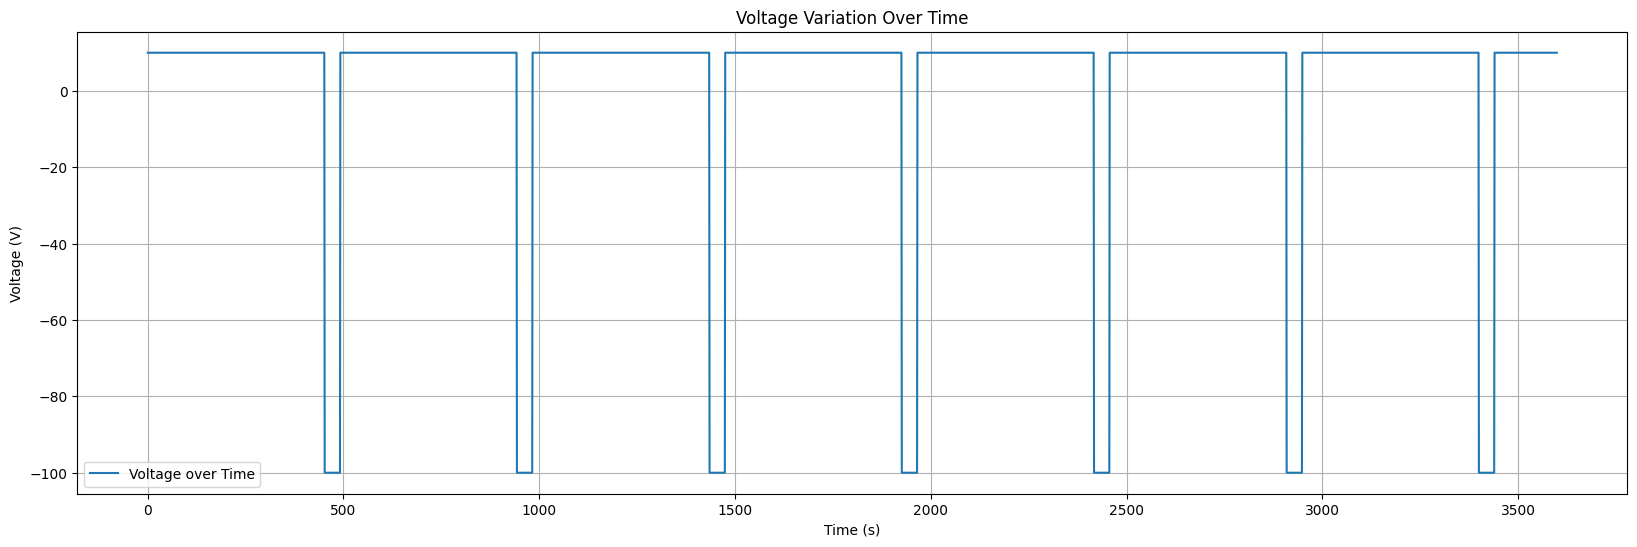

In [45]:
k = 5.0e-3
q = 3.0
D = 2.0
theta = 50 * np.pi / 180
times = np.arange(0, 3600)
voltage_levels = (10.0, -100.0)
velocity = 0.05

voltage = voltage_graph(k, q, D, theta, times, voltage_levels, velocity)

plt.figure(figsize=(20, 6))
plt.plot(voltage, label="Voltage over Time")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Voltage Variation Over Time")
plt.grid()
plt.legend()
plt.show()